# Label Frames & Train Frame Classifier

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook allows you to label the individual frames in a video from which a classifier in the sklearn library can be trained.

Notebook exports: labelled frames in a csv file and a trained model in a joblib file.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Labeller](#1.-Detect-Pose-&-Label)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)

# 0. Import Libraries & Setup

In [1]:
folder_name = 'bicep-curl-videos'
output_input_csv_filename = 'bicep-curl-phases-frames.csv'

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import pickle
from joblib import dump, load

import cv2
import mediapipe as mp

import os

In [3]:
all_landmarks = [] # List of dictionaries storing all the landmarks

def label_landmarks(landmarks, label):
    unboxed_landmarks = {}
    unboxed_landmarks['label'] = label # Label of the keypoint's coordinates
    
    # Store all the keypoint's x0,y0,z0...z32 coordinates in dictionary
    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append(unboxed_landmarks)

# 1. Detect Pose & Label

The code below is used to label frames in all the videos in a folder. First we find the training set and set aside the test set in the evaluation.

- Press 'e' to label a frame as having too much elbow movement
- Press 's' to label a frame as having too much shoulder movement
- Press 'g' to label a frame as being good

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = []

directory = os.fsencode(folder_name)

for file in os.listdir(directory):
    all_videos.append(os.fsdecode(file))
    
# Filenames of the videos we want to train the frame labeller on
# The test set is in f1-gen-heuristic notebook, same seed is used so same train and test set is created
train_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)

exit = False

for filename in train_videos:
    cap = cv2.VideoCapture(folder_name + '/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            cv2.rectangle(image, (0,0), (225, 100), (0,0,0), -1)

            k = cv2.waitKey(1)
            # Press 'u' to label frame as elbow
            if k == 117:
                label_landmarks(results.pose_landmarks, 'up')
                cv2.putText(image, 'up', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

            # Press 'd' to label frame as shoulder
            if k == 100:
                label_landmarks(results.pose_landmarks, 'down')
                cv2.putText(image, 'down', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
                
            # Press ESC to quit
            if k == 27:
                exit = True
                break

            cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        if exit == True:
            break

In [5]:
# Save the data in a csv
landmarks_df = pd.DataFrame(all_landmarks)
landmarks_df.to_csv(output_input_csv_filename, index=False)

In [44]:
# Read the data from a csv
landmarks_df = pd.read_csv(output_input_csv_filename)
landmarks_df

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,up,0.426571,0.214998,-0.259948,0.440606,0.193401,-0.316927,0.449129,0.192279,-0.316975,...,0.218229,0.572386,0.897916,0.713901,0.457626,0.966933,0.013123,0.424350,0.903602,0.654988
1,up,0.425828,0.215802,-0.276306,0.440624,0.193631,-0.332717,0.449338,0.192479,-0.332786,...,0.206901,0.572074,0.899050,0.741048,0.458160,0.965015,-0.008078,0.424455,0.901409,0.681464
2,up,0.425968,0.215754,-0.309926,0.441250,0.193694,-0.361082,0.450385,0.192567,-0.361103,...,0.205680,0.571257,0.900213,0.771678,0.458286,0.966906,-0.015116,0.423553,0.901763,0.702308
3,up,0.426295,0.215507,-0.301083,0.442142,0.193600,-0.356660,0.451451,0.192478,-0.356658,...,0.162253,0.571168,0.899703,0.743235,0.457676,0.968467,-0.067917,0.423455,0.901620,0.667242
4,up,0.427843,0.214164,-0.288749,0.443481,0.192895,-0.343560,0.452862,0.191801,-0.343511,...,0.170714,0.572065,0.897039,0.712349,0.456434,0.967925,-0.062189,0.424317,0.901071,0.633370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,up,0.418719,0.222083,-0.313193,0.433868,0.201831,-0.368323,0.441963,0.200779,-0.368453,...,0.315944,0.583012,0.912450,0.793071,0.465429,0.974310,0.118209,0.431136,0.918985,0.736210
170,up,0.417949,0.223467,-0.334947,0.433440,0.202476,-0.385015,0.441626,0.201652,-0.385079,...,0.296571,0.582908,0.911737,0.873065,0.466349,0.974762,0.093333,0.430807,0.917208,0.827712
171,up,0.412510,0.223989,-0.291635,0.428537,0.202525,-0.348413,0.436902,0.201761,-0.348515,...,0.316789,0.580554,0.908953,0.890808,0.468755,0.974856,0.124032,0.430426,0.916401,0.851172
172,down,0.428518,0.216709,-0.436952,0.442911,0.196730,-0.481849,0.451650,0.195144,-0.481834,...,0.323589,0.593616,0.917551,0.792432,0.446800,0.966601,0.143051,0.434976,0.911883,0.728988


In [45]:
landmarks_df['label'].value_counts()

up      88
down    86
Name: label, dtype: int64

# 2. Train & Evaluate Models

In [46]:
model_scores = [] # Used for comparing different model's scores

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                     'Accuracy': acc, 
                     'Precision': precision, 
                     'Recall': recall,
                     'F1 Score': f1}

    if display_matrix:
        labels= ['up', 'down']
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()
    
    return model_metrics

In [47]:
model_scores = [] # Used for comparing different model's scores

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(116, 99) (116,) (58, 99) (58,)


## Feature Extraction

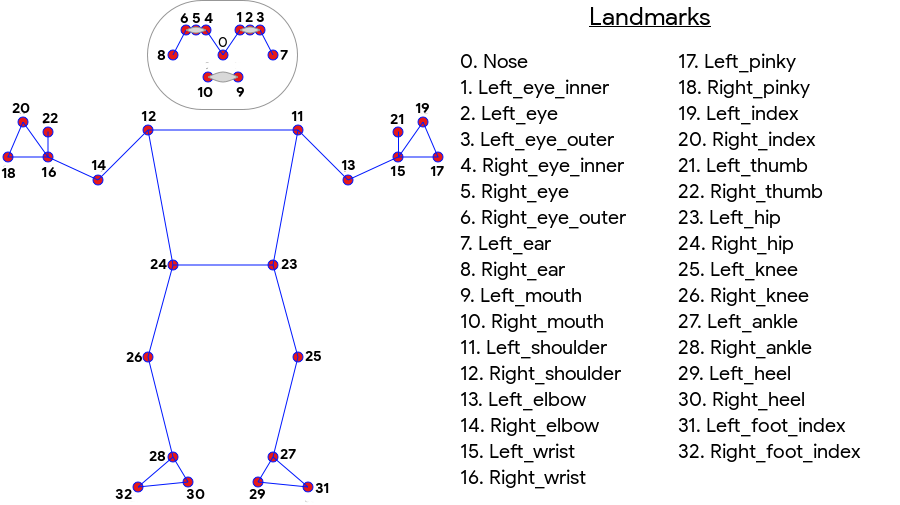

In [48]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [49]:
landmarks_df['bicep_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 13, 15), axis=1)

In [50]:
landmarks_df.head()

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,x30,y30,z30,x31,y31,z31,x32,y32,z32,bicep_angle
0,up,0.426571,0.214998,-0.259948,0.440606,0.193401,-0.316927,0.449129,0.192279,-0.316975,...,0.572386,0.897916,0.713901,0.457626,0.966933,0.013123,0.424350,0.903602,0.654988,64.403576
1,up,0.425828,0.215802,-0.276306,0.440624,0.193631,-0.332717,0.449338,0.192479,-0.332786,...,0.572074,0.899050,0.741048,0.458160,0.965015,-0.008078,0.424455,0.901409,0.681464,55.847749
2,up,0.425968,0.215754,-0.309926,0.441250,0.193694,-0.361082,0.450385,0.192567,-0.361103,...,0.571257,0.900213,0.771678,0.458286,0.966906,-0.015116,0.423553,0.901763,0.702308,57.072224
3,up,0.426295,0.215507,-0.301083,0.442142,0.193600,-0.356660,0.451451,0.192478,-0.356658,...,0.571168,0.899703,0.743235,0.457676,0.968467,-0.067917,0.423455,0.901620,0.667242,57.763586
4,up,0.427843,0.214164,-0.288749,0.443481,0.192895,-0.343560,0.452862,0.191801,-0.343511,...,0.572065,0.897039,0.712349,0.456434,0.967925,-0.062189,0.424317,0.901071,0.633370,59.976106


In [51]:
landmarks_df = landmarks_df.filter(['bicep_angle', 'label'])

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(116, 1) (116,) (58, 1) (58,)


In [52]:
X_train

,bicep_angle
96,174.488689
68,115.296633
167,161.095809
11,61.520448
97,167.475936
...,...
71,142.813936
106,133.883168
14,62.061616
92,58.052667


Trying to extract the angles seems to make the LinearSVC model perform worse.

## Models

### Linear SVC

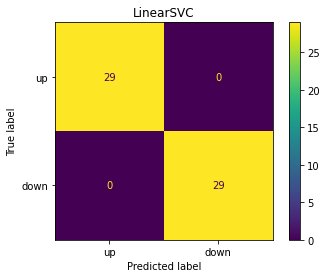

{'Classifier': 'LinearSVC', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [53]:
svc_model = make_pipeline(StandardScaler(), LinearSVC(random_state=1, tol=1e-5)).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

scores = evaluate_model('LinearSVC', y_pred, True)
model_scores.append(scores)
print(scores)

In [54]:
dump(svc_model, 'svc-bicep-curl-phases.joblib') # Export model

['svc-bicep-curl-phases.joblib']

### K-Nearest Neighbours

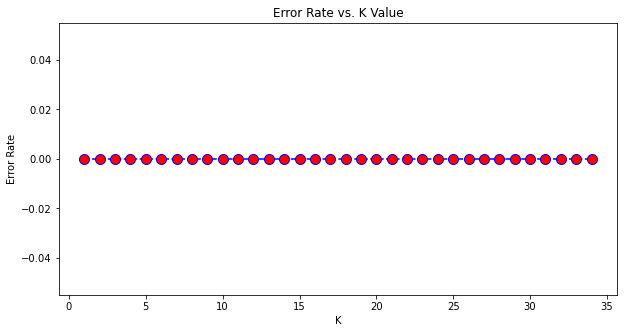

In [55]:
# Find K value with lowest error
error_rate = []
for i in range(1,35):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,5))
plt.plot(range(1,35),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

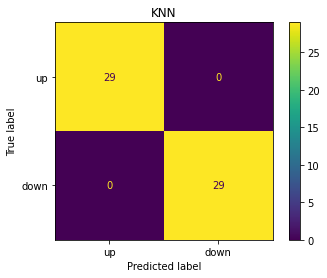

{'Classifier': 'KNN', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [56]:
knc_model = KNeighborsClassifier(1).fit(X_train, y_train)
y_pred = knc_model.predict(X_test)
scores = evaluate_model('KNN', y_pred, True)
model_scores.append(scores)
print(scores)

In [57]:
dump(knc_model, 'knc-bicep-curl-phases.joblib') # Export model

['knc-bicep-curl-phases.joblib']

### Neural Network

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


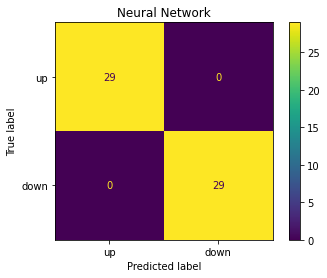

{'Classifier': 'Neural Network', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [58]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(activation='relu',
                        learning_rate='adaptive',
                        hidden_layer_sizes=(100),
                        learning_rate_init=0.01,
                        random_state=1)

mlp_model = mlp_clf.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
scores = evaluate_model('Neural Network', y_pred, True)
model_scores.append(scores)
print(scores)

In [59]:
dump(mlp_model, 'mlp-bicep-curl-phases.joblib') # Export model

['mlp-bicep-curl-phases.joblib']

### Naive Bayes

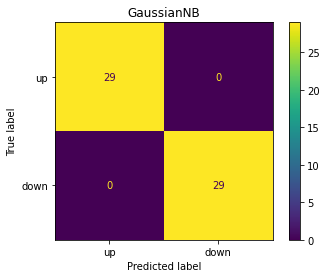

{'Classifier': 'GaussianNB', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [60]:
gnb_model = GaussianNB()
y_pred = gnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('GaussianNB', y_pred, True)

model_scores.append(scores)
print(scores)

In [61]:
dump(gnb_model, 'gnb-bicep-curl-phases.joblib') # Export model

['gnb-bicep-curl-phases.joblib']